#### **Step 1-3**

#### **Optimizing Hyperparameters**

**Technical**

In this project, we compare random search with grid search and see which optimization techniques perform better than the other in hyperparameter tuning. We first use load digits dataset, apply SGD Classifier, split the data into training and test data set, and find the top three best models for random search and grid search, based on mean validation score. Both optimization techniques have the good mean validation score at 94%. Grid search performs slightly better than random search and with less standard deviation than random search, while random search took less time than grid search.

With grid search, we found that precision, recall and f1 score on average at 96%. If we dive into the details and can observe that number zero and four has the highest F1 Score and number eight has the lowest F1 Score

In [22]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from time import time
#from sklearn.svm import SVC
import numpy as np
import scipy.stats as stats

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

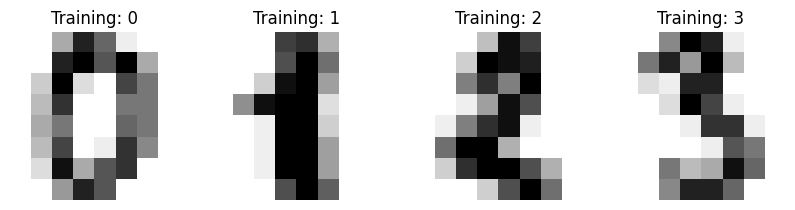

In [23]:
digits = load_digits()
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

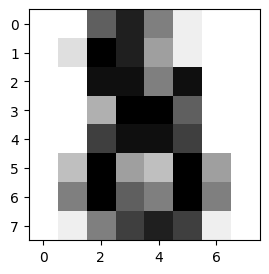

In [24]:
# Display the last digit
plt.figure(1, figsize=(3, 3))
plt.imshow(digits.images[-1], cmap=plt.cm.gray_r, interpolation="nearest")
plt.show()

In [25]:
# issue 1: optimized hyperparameters

# get some data
X, y = load_digits(return_X_y=True, n_class=10)

# build a classifier
clf = SGDClassifier(loss="hinge", penalty="elasticnet", fit_intercept=True)
#clf = SVC(gamma=0.001)

print(X,y)

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]] [0 1 2 ... 8 9 8]


In [26]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score: {0:.3f} (std: {1:.3f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
...     X, y, test_size=0.33, random_state=42)

In [28]:
# Random Search

# specify parameters and distributions to sample from
param_dist = {
    "average": [True, False],
    "l1_ratio": stats.uniform(0, 1),
    "alpha": stats.loguniform(1e-2, 1e0),
}

# run randomized search
n_iter_search = 15
random_search = RandomizedSearchCV(
    clf, param_distributions=param_dist, n_iter=n_iter_search
)

start = time()
random_search.fit(X_train, y_train)
print(
    "RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
    % ((time() - start), n_iter_search)
)
report(random_search.cv_results_)

RandomizedSearchCV took 21.65 seconds for 15 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.951 (std: 0.008)
Parameters: {'alpha': 0.14214148863319198, 'average': False, 'l1_ratio': 0.15520012256207838}

Model with rank: 2
Mean validation score: 0.939 (std: 0.024)
Parameters: {'alpha': 0.01610737842433012, 'average': False, 'l1_ratio': 0.9478037685466402}

Model with rank: 3
Mean validation score: 0.932 (std: 0.019)
Parameters: {'alpha': 0.02027586948581393, 'average': False, 'l1_ratio': 0.4992360269623398}



In [29]:
# Grid search
# use a full grid over all parameters
param_grid = {
    "average": [True, False],
    "l1_ratio": np.linspace(0, 1, num=10),
    "alpha": np.power(10, np.arange(-2, 1, dtype=float)),
}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X_train, y_train)

print(
    "GridSearchCV took %.2f seconds for %d candidate parameter settings."
    % (time() - start, len(grid_search.cv_results_["params"]))
)
report(grid_search.cv_results_)

GridSearchCV took 69.13 seconds for 60 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.950 (std: 0.009)
Parameters: {'alpha': 0.01, 'average': True, 'l1_ratio': 0.0}

Model with rank: 2
Mean validation score: 0.949 (std: 0.003)
Parameters: {'alpha': 0.01, 'average': False, 'l1_ratio': 0.0}

Model with rank: 3
Mean validation score: 0.948 (std: 0.006)
Parameters: {'alpha': 0.01, 'average': False, 'l1_ratio': 0.3333333333333333}



In [30]:
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       0.92      0.89      0.91        55
           2       0.96      1.00      0.98        52
           3       0.98      0.91      0.94        56
           4       1.00      0.98      0.99        64
           5       0.95      0.96      0.95        73
           6       0.98      0.98      0.98        57
           7       1.00      0.98      0.99        62
           8       0.80      0.92      0.86        52
           9       0.95      0.91      0.93        68

    accuracy                           0.95       594
   macro avg       0.96      0.95      0.95       594
weighted avg       0.96      0.95      0.96       594



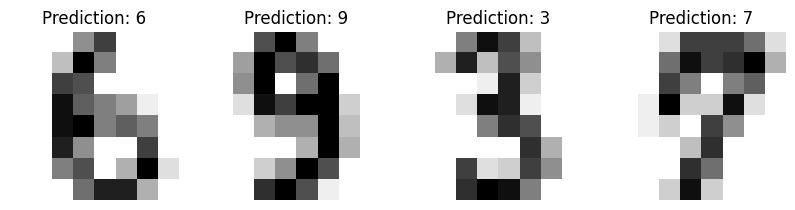

In [31]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, prediction in zip(axes, X_test, y_pred):
    ax.set_axis_off()
    image = image.reshape(8, 8)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f"Prediction: {prediction}")

Confusion matrix:
[[55  0  0  0  0  0  0  0  0  0]
 [ 0 49  2  0  0  0  0  0  4  0]
 [ 0  0 52  0  0  0  0  0  0  0]
 [ 0  0  0 51  0  1  0  0  4  0]
 [ 0  1  0  0 63  0  0  0  0  0]
 [ 0  0  0  0  0 70  1  0  0  2]
 [ 0  0  0  0  0  1 56  0  0  0]
 [ 0  0  0  0  0  0  0 61  0  1]
 [ 0  3  0  0  0  1  0  0 48  0]
 [ 0  0  0  1  0  1  0  0  4 62]]


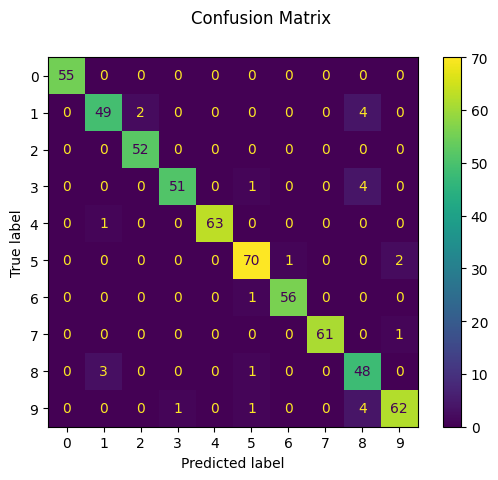

In [32]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

Reference

https://scikit-learn.org/stable/auto_examples/datasets/plot_digits_last_image.html#sphx-glr-auto-examples-datasets-plot-digits-last-image-py

Reference

Randomized Search
https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html#sphx-glr-auto-examples-applications-plot-face-recognition-py

Dataset: http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz

https://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html#sphx-glr-auto-examples-decomposition-plot-faces-decomposition-py

https://scikit-learn.org/stable/auto_examples/cluster/plot_dict_face_patches.html#sphx-glr-auto-examples-cluster-plot-dict-face-patches-py

https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_multioutput_face_completion.html#sphx-glr-auto-examples-miscellaneous-plot-multioutput-face-completion-py

https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py


https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html#sphx-glr-auto-examples-classification-plot-digits-classification-py

Grid search

https://duchesnay.github.io/pystatsml/auto_gallery/ml_lab_face_recognition.html

https://scikit-learn.sourceforge.net/0.8/auto_examples/applications/face_recognition.html


Bayesian Optimization

https://towardsdatascience.com/bayesian-optimization-with-python-85c66df711ec

https://drlee.io/bayesian-optimization-with-python-b544255757d3

https://machinelearningmastery.com/what-is-bayesian-optimization/

https://modal-python.readthedocs.io/en/latest/content/examples/bayesian_optimization.html

https://www.analyticsvidhya.com/blog/2021/05/bayesian-optimization-bayes_opt-or-hyperopt/


https://pyro.ai/examples/bo.html

Libraries ( imports )

In [33]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import ShuffleSplit, cross_validate
import pandas as pd
from sklearn.model_selection import ShuffleSplit, cross_validate
from sklearn.model_selection import validation_curve
from mlxtend.evaluate import bias_variance_decomp
import plotly.graph_objects as go


import warnings
warnings.filterwarnings("ignore")



#  Optimizing the Bias-Variance Tradeoff

In [34]:
# read dataset from URL
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
cls = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'Class']
dataset = pd.read_csv(url, names=cls)
dataset.head()

,sepal-length,sepal-width,petal-length,petal-width,Class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [35]:

# divide the dataset into class and target variable
X = dataset.iloc[:, 0:4].values
y = dataset.iloc[:, 4].values

# Preprocess the dataset and divide into train and test
sc = StandardScaler()
X = sc.fit_transform(X)
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 1)



In [36]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(random_state=42)

cv = ShuffleSplit(n_splits=40, test_size=0.3, random_state=0)
cv_results = cross_validate(regressor, X, y, cv=cv, scoring="neg_mean_absolute_error")
cv_results = pd.DataFrame(cv_results)

cv_results["test_error"] = -cv_results["test_score"]
cv_results.head()

,fit_time,score_time,test_score,test_error
0,0.001475,0.011101,-0.022222,0.022222
1,0.011484,0.000538,-0.066667,0.066667
2,0.011499,0.000515,-0.044444,0.044444
3,0.014509,0.000550,-0.133333,0.133333
4,0.008441,0.000537,-0.022222,0.022222


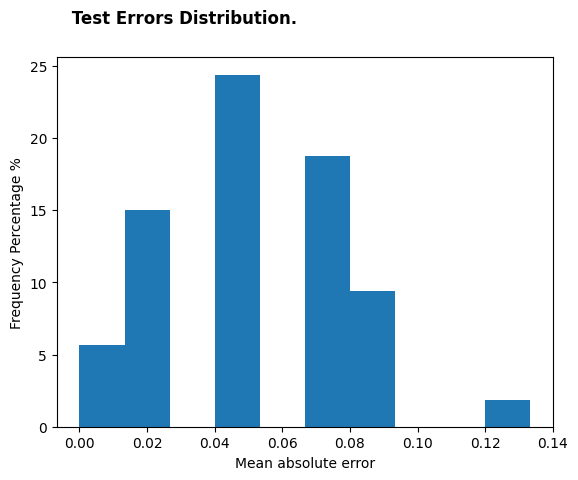

In [37]:

plt.hist(cv_results["test_error"], density=True)
# cv_results["test_error"].plot.hist(bins=10, edgecolor="black")
plt.xlabel("Mean absolute error")
plt.ylabel("Frequency Percentage %")
plt.suptitle(
    " Test Errors Distribution.", fontweight="bold", horizontalalignment="right"
)
plt.show()

In [38]:
import pandas as pd
from sklearn.model_selection import ShuffleSplit, cross_validate

cv = ShuffleSplit(n_splits=30, test_size=0.2)
cv_results = cross_validate(
    regressor,
    X,
    y,
    cv=cv,
    scoring="neg_mean_absolute_error",
    return_train_score=True,
    n_jobs=2,
)
cv_results = pd.DataFrame(cv_results)

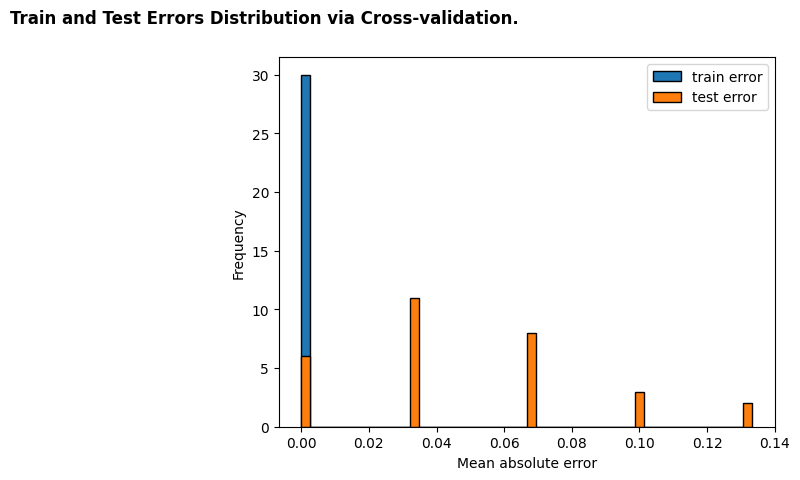

In [39]:
scores = pd.DataFrame()
scores[["train error", "test error"]] = -cv_results[["train_score", "test_score"]]

scores.plot.hist(bins=50, edgecolor="black")
plt.xlabel("Mean absolute error")
plt.suptitle(
    "Train and Test Errors Distribution via Cross-validation.",
    fontweight="bold",
    horizontalalignment="right",
)
plt.show()

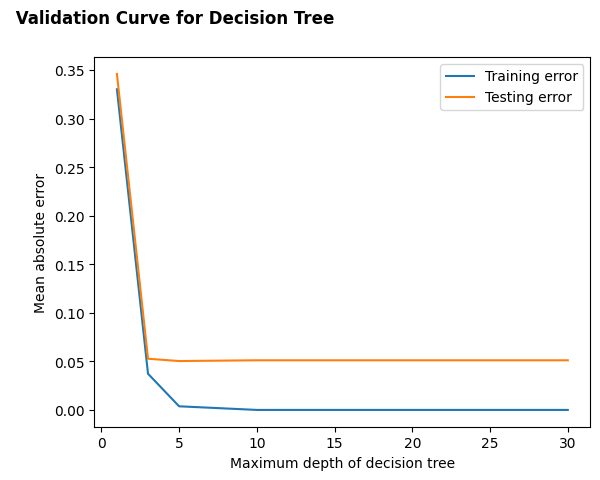

In [40]:
from sklearn.model_selection import validation_curve

max_depth = [1, 3, 5, 10, 15, 20, 25, 30]
train_scores, test_scores = validation_curve(
    regressor,
    X,
    y,
    param_name="max_depth",
    param_range=max_depth,
    cv=cv,
    scoring="neg_mean_absolute_error",
    n_jobs=2,
)
train_errors, test_errors = -train_scores, -test_scores

plt.plot(max_depth, train_errors.mean(axis=1), label="Training error")
plt.plot(max_depth, test_errors.mean(axis=1), label="Testing error")
plt.legend()

plt.xlabel("Maximum depth of decision tree")
plt.ylabel("Mean absolute error")
plt.suptitle(
    " Validation Curve for Decision Tree",
    fontweight="bold",
    horizontalalignment="right",
)
plt.show()

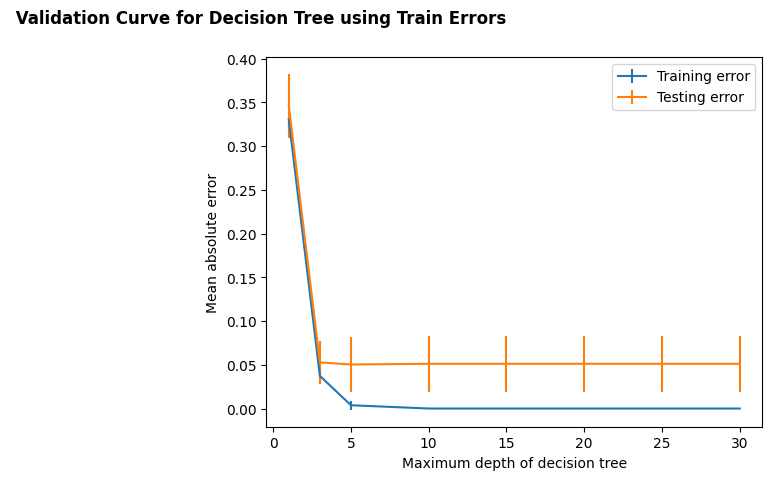

In [41]:
plt.errorbar(
    max_depth,
    train_errors.mean(axis=1),
    yerr=train_errors.std(axis=1),
    label="Training error",
)
plt.errorbar(
    max_depth,
    test_errors.mean(axis=1),
    yerr=test_errors.std(axis=1),
    label="Testing error",
)
plt.legend()

plt.xlabel("Maximum depth of decision tree")
plt.ylabel("Mean absolute error")
plt.suptitle(
    " Validation Curve for Decision Tree using Train Errors",
    fontweight="bold",
    horizontalalignment="right",
)
plt.show()

In [42]:
from mlxtend.evaluate import bias_variance_decomp
import plotly.graph_objects as go

max_levels = list(range(1, 50))
levels = []
squared_bias_plus_variance = []
for level in max_levels:
    model = DecisionTreeRegressor(max_depth=level)
    model.fit(X_train, y_train)
    mse, bias, var = bias_variance_decomp(
        model,
        X_train,
        y_train,
        X_test,
        y_test,
        loss="mse",
        num_rounds=200,
        random_seed=1,
    )
    score = model.score(X_test, y_test)
    squared_bias_plus_variance.append(bias**2 + var)
    levels.append(level)



scatter = go.Scatter(x=levels, y=squared_bias_plus_variance)
layout = go.Layout(
    title=" Bias variance tradeoff",
    xaxis=dict(title="levels"),
    yaxis=dict(title="bias^2+variance"),
)
go.Figure(data=[scatter], layout=layout)

# **Ensemble Learnings: Bagging, Boosting and Stacking**



**Technical**

In [43]:
# import all necessary libraries

import warnings

import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import pandas as pd
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    StackingClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

# for stacking model later
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

warnings.filterwarnings("ignore")

In [45]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import files
uploaded = files.upload()

Mounted at /content/drive


Saving Data.csv to Data.csv


In [50]:
data_df = pd.read_csv('/content/Data.csv')

data_df.head()

,Unnamed: 0,Date,LUXXX,MSCI ARGENTINA,BLP ORIENTE MEDIO,MSCI AUSTRALIA,MSCI AUSTRIA,MSCI BELGIUM,MSCI BRAZIL,MSCI CANADA,...,MSCI NORWAY,MSCI PERU,MSCI RUSSIA,MSCI SINGAPORE,MSCI SOUTH AFRICA,MSCI SPAIN,MSCI SWEDEN,MSCI SWITZERLAND,MSCI UK,MSCI USA
0,1,1-Jan-16,1390.716,2376.29,3525.9150,1068.79,106.70,105.38,1036.23,1663.27,...,2373.17,811.96,404.73,1507.8101,1255.75,108.40,11136.65,1148.37,1818.40,1949.70
1,2,8-Jan-16,1291.267,2260.85,3280.6683,1005.56,97.66,99.35,952.01,1586.18,...,2209.38,751.09,388.05,1437.6600,1177.76,101.00,10389.93,1075.30,1722.00,1831.88
2,3,15-Jan-16,1257.086,2217.50,3118.2981,985.38,93.54,97.32,904.64,1541.08,...,2095.60,720.23,344.45,1372.9800,1133.72,97.34,10042.32,1056.01,1692.43,1789.56
3,4,22-Jan-16,1254.167,2281.98,2935.0677,985.87,95.79,100.73,879.17,1582.10,...,2173.55,745.96,367.44,1350.0500,1160.48,99.21,10469.07,1076.48,1719.61,1814.12
4,5,29-Jan-16,1298.240,2462.19,3134.0840,1005.56,96.93,103.05,958.97,1638.84,...,2214.88,825.18,400.93,1375.1000,1239.58,100.06,10432.42,1087.17,1774.40,1843.88


In [51]:

data_df["Date"] = pd.to_datetime(data_df["Date"])

In [52]:
# Set Target Index for predicting
target_ETF = "LUXXX"

# Use returns instead of prices for other Indices
# Other Indices used as Index_features
ETF_features = data_df.loc[:, ~data_df.columns.isin(["Date", target_ETF])].columns
data_df[ETF_features] = data_df[ETF_features].pct_change()

data_df[target_ETF + "_returns"] = data_df[target_ETF].pct_change()

# Create Target Column.
# Shift period for target column
data_df[target_ETF + "_returns" + "_Shift"] = data_df[target_ETF + "_returns"].shift(-1)

# Strategy to take long position for anticipated returns of 0.5%
data_df["Target"] = np.where(
    (data_df[target_ETF + "_returns_Shift"].abs() > 0.025), 1, 0
)

In [53]:
# Four country indices used.
feats = ["MSCI KOREA", "MSCI DENMARK", "MSCI FRANCE", "MSCI NORWAY"]

# creating the technical indicators
data_df["SMA_5"] = data_df[target_ETF].rolling(5).mean()
data_df["SMA_15"] = data_df[target_ETF].rolling(15).mean()
data_df["SMA_ratio"] = data_df["SMA_15"] / data_df["SMA_5"]

# Can drop SMA columns since not needed anymore.
data_df.drop(["SMA_5", "SMA_15"], axis=1, inplace=True)


# shift the price of the target by 1 unit previous in time
data_df["Diff"] = data_df[target_ETF] - data_df[target_ETF].shift(1)
data_df["Up"] = data_df["Diff"]
data_df.loc[(data_df["Up"] < 0), "Up"] = 0

data_df["Down"] = data_df["Diff"]
data_df.loc[(data_df["Down"] > 0), "Down"] = 0
data_df["Down"] = abs(data_df["Down"])

data_df["avg_5up"] = data_df["Up"].rolling(5).mean()
data_df["avg_5down"] = data_df["Down"].rolling(5).mean()

data_df["avg_15up"] = data_df["Up"].rolling(15).mean()
data_df["avg_15down"] = data_df["Down"].rolling(15).mean()

data_df["RS_5"] = data_df["avg_5up"] / data_df["avg_5down"]
data_df["RS_15"] = data_df["avg_15up"] / data_df["avg_15down"]

data_df["RSI_5"] = 100 - (100 / (1 + data_df["RS_5"]))
data_df["RSI_15"] = 100 - (100 / (1 + data_df["RS_15"]))

data_df["RSI_ratio"] = data_df["RSI_5"] / data_df["RSI_15"]

# Can drop RS Calc columns columns
data_df.drop(
    ["Diff", "Up", "Down", "avg_5up", "avg_5down", "avg_15up", "avg_15down"],
    axis=1,
    inplace=True,
)

data_df["RC"] = data_df[target_ETF].pct_change(periods=15)

# all_feats
feats.append("SMA_ratio")
feats.append("RSI_ratio")
feats.append("RC")

In [54]:
# Train/Test split
# Train/Test split. No NaNs in the data.
NoNaN_df = data_df.dropna()
X = NoNaN_df[feats]

X = X.iloc[:, :]  # .values
y = NoNaN_df.loc[:, "Target"]  # .values

del NoNaN_df

# from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [55]:
from sklearn.model_selection import GridSearchCV

In [56]:
# parameters for AdaBoost
param_grid = {"n_estimators": [10, 20, 50, 100], "learning_rate": [0.1, 0.25, 0.5, 1.0]}

gridAdBoost = GridSearchCV(
    AdaBoostClassifier(), param_grid, refit=True, verbose=3, cv=3
)
# fitting the model for grid search
gridAdBoost.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END learning_rate=0.1, n_estimators=10;, score=0.698 total time=   0.0s
[CV 2/3] END learning_rate=0.1, n_estimators=10;, score=0.683 total time=   0.0s
[CV 3/3] END learning_rate=0.1, n_estimators=10;, score=0.710 total time=   0.0s
[CV 1/3] END learning_rate=0.1, n_estimators=20;, score=0.698 total time=   0.0s
[CV 2/3] END learning_rate=0.1, n_estimators=20;, score=0.603 total time=   0.0s
[CV 3/3] END learning_rate=0.1, n_estimators=20;, score=0.694 total time=   0.0s
[CV 1/3] END learning_rate=0.1, n_estimators=50;, score=0.698 total time=   0.1s
[CV 2/3] END learning_rate=0.1, n_estimators=50;, score=0.571 total time=   0.1s
[CV 3/3] END learning_rate=0.1, n_estimators=50;, score=0.677 total time=   0.1s
[CV 1/3] END learning_rate=0.1, n_estimators=100;, score=0.667 total time=   0.2s
[CV 2/3] END learning_rate=0.1, n_estimators=100;, score=0.571 total time=   0.2s
[CV 3/3] END learning_rate=0.1, n_estimators=1

GridSearchCV(cv=3, estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [0.1, 0.25, 0.5, 1.0],
                         'n_estimators': [10, 20, 50, 100]},
             verbose=3)

In [57]:
# print best parameter after tuning
print(gridAdBoost.best_params_)

# print how our AdaBoost model looks after hyper-parameter tuning
print(gridAdBoost.best_estimator_)

{'learning_rate': 0.1, 'n_estimators': 10}
AdaBoostClassifier(learning_rate=0.1, n_estimators=10)


In [58]:
# parameters for Gradient Boosting Classifier
param_grid = {"n_estimators": [10, 20, 50, 100], "learning_rate": [0.1, 0.25, 0.5, 1.0]}

GBgrid = GridSearchCV(
    GradientBoostingClassifier(), param_grid, refit=True, verbose=3, cv=3
)

# fitting the model for grid search
GBgrid.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END learning_rate=0.1, n_estimators=10;, score=0.698 total time=   0.1s
[CV 2/3] END learning_rate=0.1, n_estimators=10;, score=0.635 total time=   0.0s
[CV 3/3] END learning_rate=0.1, n_estimators=10;, score=0.645 total time=   0.0s
[CV 1/3] END learning_rate=0.1, n_estimators=20;, score=0.635 total time=   0.0s
[CV 2/3] END learning_rate=0.1, n_estimators=20;, score=0.619 total time=   0.0s
[CV 3/3] END learning_rate=0.1, n_estimators=20;, score=0.661 total time=   0.0s
[CV 1/3] END learning_rate=0.1, n_estimators=50;, score=0.667 total time=   0.1s
[CV 2/3] END learning_rate=0.1, n_estimators=50;, score=0.619 total time=   0.1s
[CV 3/3] END learning_rate=0.1, n_estimators=50;, score=0.677 total time=   0.1s
[CV 1/3] END learning_rate=0.1, n_estimators=100;, score=0.587 total time=   0.1s
[CV 2/3] END learning_rate=0.1, n_estimators=100;, score=0.635 total time=   0.1s
[CV 3/3] END learning_rate=0.1, n_estimators=1

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1, 0.25, 0.5, 1.0],
                         'n_estimators': [10, 20, 50, 100]},
             verbose=3)

In [59]:
# print best parameter after tuning
print(GBgrid.best_params_)

# print how our Gradient Boost model looks after hyper-parameter tuning
print(GBgrid.best_estimator_)

{'learning_rate': 0.25, 'n_estimators': 50}
GradientBoostingClassifier(learning_rate=0.25, n_estimators=50)


In [60]:
# parameters for XG Boosting Classifier
param_grid = {"n_estimators": [10, 20, 50, 100], "learning_rate": [0.1, 0.25, 0.5, 1.0]}

XGB_model = xgb.XGBClassifier()
XGBgrid = GridSearchCV(XGB_model, param_grid, refit=True, verbose=3, cv=3)

# fitting the model for grid search
XGBgrid.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END learning_rate=0.1, n_estimators=10;, score=0.571 total time=   0.1s
[CV 2/3] END learning_rate=0.1, n_estimators=10;, score=0.667 total time=   0.1s
[CV 3/3] END learning_rate=0.1, n_estimators=10;, score=0.661 total time=   0.1s
[CV 1/3] END learning_rate=0.1, n_estimators=20;, score=0.619 total time=   0.4s
[CV 2/3] END learning_rate=0.1, n_estimators=20;, score=0.683 total time=   0.1s
[CV 3/3] END learning_rate=0.1, n_estimators=20;, score=0.694 total time=   0.2s
[CV 1/3] END learning_rate=0.1, n_estimators=50;, score=0.651 total time=   0.1s
[CV 2/3] END learning_rate=0.1, n_estimators=50;, score=0.619 total time=   0.2s
[CV 3/3] END learning_rate=0.1, n_estimators=50;, score=0.677 total time=   0.9s
[CV 1/3] END learning_rate=0.1, n_estimators=100;, score=0.619 total time=   0.1s
[CV 2/3] END learning_rate=0.1, n_estimators=100;, score=0.619 total time=   0.3s
[CV 3/3] END learning_rate=0.1, n_estimators=1

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.25, 0.5, 1.0],
                         'n_estimators': [10, 20, 50, 100]},
             verbose=3)

In [61]:
# print best parameter after tuning
print(XGBgrid.best_params_)

# print how our XGBoost model looks after hyper-parameter tuning
print(XGBgrid.best_estimator_)

{'learning_rate': 0.1, 'n_estimators': 20}
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=20, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


In [62]:
# Train with Tuned Random Forest
# Create a tuned RF Classifier
bagmodel_tuned = RandomForestClassifier(
    max_depth=2, min_samples_split=8, n_estimators=10, random_state=10
)

bagmodel_tuned.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, min_samples_split=8, n_estimators=10,
                       random_state=10)

In [63]:
clf1 = DecisionTreeClassifier()  # Decision Tree

clf2 = SVC(kernel="rbf")  # Support Vector Classifier

clf3 = GaussianNB()  # Gaussian Naive Bayes

est_rs = [("DTree", clf1), ("SVM", clf2), ("NB", clf3)]
# Meta model
mylr = LogisticRegression()
# creating a stacking classifier
stackingCLF = StackingClassifier(
    estimators=est_rs, final_estimator=mylr, stack_method="auto", cv=3
)
stackingCLF.fit(X_train, y_train)

StackingClassifier(cv=3,
                   estimators=[('DTree', DecisionTreeClassifier()),
                               ('SVM', SVC()), ('NB', GaussianNB())],
                   final_estimator=LogisticRegression())

In [64]:
# Create a tuned AdaBoost Classifier
AdaBoost_tuned = AdaBoostClassifier(learning_rate=0.1, n_estimators=10)

# Create a tuned Gradient Boosting Classifier
GB_tuned = GradientBoostingClassifier(learning_rate=0.1, n_estimators=10)

# Create a tuned XGBoost Classifier
XGB_tuned = xgb.XGBClassifier(learning_rate=0.25, n_estimators=10)

# train boosting models
AdaBoost_tuned.fit(X_train, y_train)
GB_tuned.fit(X_train, y_train)
XGB_tuned.fit(X_train, y_train)
print("Training complete")

Training complete


In [65]:
from sklearn.metrics import roc_auc_score, roc_curve

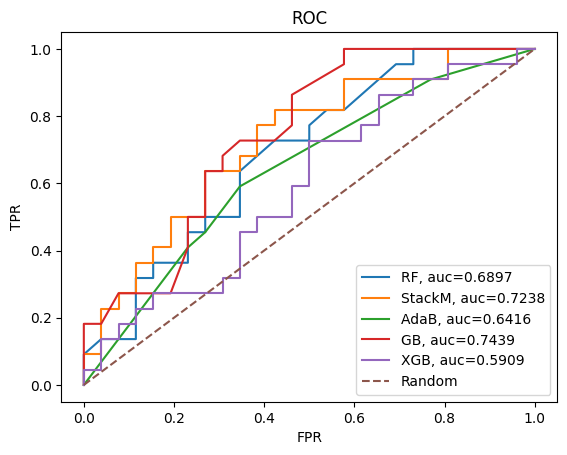

In [66]:
# predicted probabilities generated by models
y_pred_probaStack = stackingCLF.predict_proba(X_test)  # stacking
y_pred_probaRF = bagmodel_tuned.predict_proba(X_test)  # RF
y_pred_probaAdB = AdaBoost_tuned.predict_proba(X_test)  # AdaBoost
y_pred_probaGb = GB_tuned.predict_proba(X_test)  # `GradBoost`
y_pred_probaXGB = XGB_tuned.predict_proba(X_test)  # XGBoost

# Stacking ROC dependencies
fpr, tpr, _ = roc_curve(y_test, y_pred_probaStack[:, 1])
auc = round(roc_auc_score(y_test, y_pred_probaStack[:, 1]), 4)

# RF ROC dependencies
fpr_RF, tpr_RF, _ = roc_curve(y_test, y_pred_probaRF[:, 1])
auc_RF = round(roc_auc_score(y_test, y_pred_probaRF[:, 1]), 4)

# AdaBoost ROC dependencies
fpr_AB, tpr_AB, _ = roc_curve(y_test, y_pred_probaAdB[:, 1])
auc_AB = round(roc_auc_score(y_test, y_pred_probaAdB[:, 1]), 4)

# Gradient Boost ROC dependencies
fpr_GB, tpr_GB, _ = roc_curve(y_test, y_pred_probaGb[:, 1])
auc_GB = round(roc_auc_score(y_test, y_pred_probaGb[:, 1]), 4)

# XGB ROC dependencies
fpr_XGB, tpr_XGB, _ = roc_curve(y_test, y_pred_probaXGB[:, 1])
auc_XGB = round(roc_auc_score(y_test, y_pred_probaXGB[:, 1]), 4)

# RF Model
plt.plot(fpr_RF, tpr_RF, label="RF, auc=" + str(auc_RF))
# Stacking Model
plt.plot(fpr, tpr, label="StackM, auc=" + str(auc))
# AdaBoost Model
plt.plot(fpr_AB, tpr_AB, label="AdaB, auc=" + str(auc_AB))
# `GradBoost` Model
plt.plot(fpr_GB, tpr_GB, label="GB, auc=" + str(auc_GB))
# XGBoost Model
plt.plot(fpr_XGB, tpr_XGB, label="XGB, auc=" + str(auc_XGB))

# Random guess model
plt.plot(fpr, fpr, "--", label="Random")
plt.title("ROC")
plt.ylabel("TPR")
plt.xlabel("FPR")

plt.legend(loc=4)
plt.show()